# Adaptive Fashion Clustering - DeepFashion2 (Kaggle Download)
## EfficientNet-B3 + Dynamic K-Means Clustering

**Setup:**
1. Runtime → Change runtime type → **T4 GPU**
2. Get Kaggle API key from https://www.kaggle.com/settings
3. Upload kaggle.json when prompted
4. Dataset downloads automatically (~20-40 min)

**What this does:**
- Downloads DeepFashion2 from Kaggle (~15GB)
- Saves to Google Drive (persists across sessions)
- Trains adaptive clustering model
- Discovers fashion categories automatically

## Initial Setup

In [ ]:
# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("WARNING: No GPU detected! Go to Runtime → Change runtime type → GPU")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.83 GB


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create working directories in Drive
import os
DRIVE_ROOT = '/content/drive/MyDrive/DeepFashion_Project'
os.makedirs(DRIVE_ROOT, exist_ok=True)
os.makedirs(f'{DRIVE_ROOT}/checkpoints', exist_ok=True)
os.makedirs(f'{DRIVE_ROOT}/feature_cache', exist_ok=True)

print(f"Working directory: {DRIVE_ROOT}")

In [ ]:
# Install required packages
!pip install -q efficientnet-pytorch
!pip install -q kaggle

print("Dependencies installed")

In [ ]:
# Upload your kaggle.json file
from google.colab import files
import os

print("📤 Upload your kaggle.json file:")
print("(Get it from: https://www.kaggle.com/settings → API → Create New API Token)\n")
uploaded = files.upload()

# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\nKaggle credentials configured")

In [ ]:
from pathlib import Path

# Check how many images are currently synced
train_dir = Path('/content/drive/MyDrive/DeepFashion_Project/datasets/deepfashion2_original_images/train/image')
val_dir = Path('/content/drive/MyDrive/DeepFashion_Project/datasets/deepfashion2_original_images/validation/image')

print("Current sync status:")
print(f"  Train images: {len(list(train_dir.glob('*.jpg'))) if train_dir.exists() else 0}")
print(f"  Val images: {len(list(val_dir.glob('*.jpg'))) if val_dir.exists() else 0}")

Current sync status:
  Train images: 40940
  Val images: 25988


## Download DeepFashion2 Dataset

Download from: https://www.kaggle.com/datasets/thusharanair/deepfashion2-original-with-dataframes



## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from efficientnet_pytorch import EfficientNet

import numpy as np
from PIL import Image
from pathlib import Path
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict
import pickle
from tqdm.notebook import tqdm
import json
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Configuration
**Dataset will be at:** `MyDrive/DeepFashion_Project/datasets/deepfashion2_original_images`  


In [ ]:
class Config:
    # ===== UPDATE THIS PATH TO YOUR DATASET =====
    # If you uploaded to a different location, change this:
    DEEPFASHION_ROOT = '/content/drive/MyDrive/DeepFashion_Project/datasets/deepfashion2_original_images'

    # Other paths
    CACHE_DIR = '/content/drive/MyDrive/DeepFashion_Project/feature_cache'
    CHECKPOINT_DIR = '/content/drive/MyDrive/DeepFashion_Project/checkpoints'

    # Model architecture
    EFFICIENTNET_DIM = 1536
    PROJECTION_DIM = 256
    HIDDEN_DIM = 512

    # Clustering
    INITIAL_K = 10
    MAX_K = 25
    REASSIGN_FREQUENCY = 1
    NOVELTY_BUFFER_SIZE = 80
    CONFIDENCE_THRESHOLD = 0.6
    DISTANCE_STD_MULTIPLIER = 2.0

    # Training (optimized for Colab T4 GPU)
    BATCH_SIZE = 32
    NUM_EPOCHS = 8
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5
    NUM_WORKERS = 2
    IMAGE_SIZE = 300

    # Subset size for faster training (set to None for full dataset)
    MAX_TRAIN_SAMPLES = None  # Use all available
    MAX_VAL_SAMPLES = None    # Use all available

config = Config()

print("Configuration:")
print(f"  Dataset: {config.DEEPFASHION_ROOT}")
print(f"  Checkpoints: {config.CHECKPOINT_DIR}")
print(f"  Batch size: {config.BATCH_SIZE}")
print(f"  Epochs: {config.NUM_EPOCHS}")
print(f"  Initial clusters: {config.INITIAL_K}")

Configuration:
  Dataset: /content/drive/MyDrive/DeepFashion_Project/datasets/deepfashion2_original_images
  Checkpoints: /content/drive/MyDrive/DeepFashion_Project/checkpoints
  Batch size: 32
  Epochs: 8
  Initial clusters: 10


## Dataset Loader (DeepFashion2 Specific)

In [ ]:
class DeepFashion2Dataset(Dataset):
    """
    DeepFashion2 Dataset Loader for Kaggle version

    Expected structure:
    root_dir/
    ├── train/
    │   ├── annos/
    │   └── image/  ← JPG files here
    ├── validation/
    │   ├── annos/
    │   └── image/  ← JPG files here
    └── test/
        ├── annos/
        └── image/  ← JPG files here
    """

    def __init__(self, root_dir, split='train', transform=None, max_samples=None):
        self.root_dir = Path(root_dir)
        self.split = split
        self.transform = transform

        # Load image paths
        self.image_paths = self._load_image_paths()

        if max_samples:
            self.image_paths = self.image_paths[:max_samples]

        print(f"Loaded {len(self.image_paths)} images for '{split}' split")

    def _load_image_paths(self):
        """Load image paths from DeepFashion2 structure"""
        # Map 'val' to 'validation' folder name
        split_folder = 'validation' if self.split == 'val' else self.split

        # Expected path: root_dir/train/image/ or root_dir/validation/image/
        image_dir = self.root_dir / split_folder / 'image'

        if not image_dir.exists():
            raise ValueError(
                f"Image directory not found: {image_dir}\n"
                f"Expected structure: {self.root_dir}/{split_folder}/image/\n"
                f"\nAvailable folders in {self.root_dir}:\n"
                f"{list(self.root_dir.iterdir()) if self.root_dir.exists() else 'Root does not exist'}"
            )

        print(f"Loading images from: {image_dir}")

        # Load all JPG images
        image_paths = []
        for ext in ['*.jpg', '*.jpeg', '*.JPG', '*.JPEG']:
            image_paths.extend(list(image_dir.glob(ext)))

        if len(image_paths) == 0:
            raise ValueError(f"No images found in {image_dir}")

        return sorted(image_paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            image = Image.new('RGB', (config.IMAGE_SIZE, config.IMAGE_SIZE), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        return {
            'image': image,
            'path': str(img_path),
            'idx': idx
        }

## Data Transforms

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class AdaptiveFashionClusterer(nn.Module):
    """Adaptive Fashion Clustering Model"""

    def __init__(self, initial_k=10, projection_dim=256, hidden_dim=512, pretrained=True):
        super(AdaptiveFashionClusterer, self).__init__()

        self.k = initial_k
        self.projection_dim = projection_dim

        # EfficientNet-B3 backbone. It's pretrained on ImageNet
        if pretrained:
            self.efficientnet = EfficientNet.from_pretrained('efficientnet-b3')
        else:
            self.efficientnet = EfficientNet.from_name('efficientnet-b3')

        self.efficientnet._fc = nn.Identity()
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(config.EFFICIENTNET_DIM, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, projection_dim),
            nn.BatchNorm1d(projection_dim),
            nn.ReLU(inplace=True)
        )

        # Cluster prediction head
        self.cluster_head = nn.Linear(projection_dim, self.k)

        self._initialize_weights()
        self.freeze_backbone()

    def _initialize_weights(self):
        for m in [self.projection, self.cluster_head]:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def freeze_backbone(self):
        for param in self.efficientnet.parameters():
            param.requires_grad = False

    def unfreeze_backbone(self):
        for param in self.efficientnet.parameters():
            param.requires_grad = True

    def update_cluster_head(self, new_k):
        if new_k != self.k:
            print(f"Updating cluster head: {self.k} -> {new_k} clusters")
            old_head = self.cluster_head
            self.k = new_k
            self.cluster_head = nn.Linear(self.projection_dim, new_k).to(old_head.weight.device)
            nn.init.xavier_uniform_(self.cluster_head.weight)
            nn.init.constant_(self.cluster_head.bias, 0)

    def forward_features(self, images):
        features = self.efficientnet.extract_features(images)
        pooled = self.global_pool(features)
        pooled = pooled.view(pooled.size(0), -1)
        return pooled

    def forward(self, images, return_features=False):
        backbone_features = self.forward_features(images)
        projected = self.projection(backbone_features)
        logits = self.cluster_head(projected)

        if return_features:
            return logits, {
                'backbone_features': backbone_features,
                'projected_features': projected,
                'num_clusters': self.k
            }
        return logits

    def get_embeddings(self, images):
        with torch.no_grad():
            backbone_features = self.forward_features(images)
            projected = self.projection(backbone_features)
        return projected

## Clustering Module

In [ ]:
class AdaptiveClusteringModule:
    """Adaptive K-Means clustering with novelty detection"""

    def __init__(self, initial_k=10, max_k=25):
        self.k = initial_k
        self.max_k = max_k
        self.kmeans = None
        self.cluster_centers = None
        self.novelty_buffer = []
        self.history = {
            'k_values': [initial_k],
            'silhouette_scores': [],
            'inertia': []
        }

    def fit(self, features):
        print(f"Clustering {len(features)} samples into {self.k} clusters...")

        self.kmeans = MiniBatchKMeans(
            n_clusters=self.k,
            batch_size=512,
            random_state=42,
            max_iter=100
        )

        labels = self.kmeans.fit_predict(features)
        self.cluster_centers = self.kmeans.cluster_centers_

        if len(features) > self.k:
            try:
                silhouette = silhouette_score(features, labels, sample_size=min(3000, len(features)))
                self.history['silhouette_scores'].append(silhouette)
                print(f"Silhouette score: {silhouette:.4f}")
            except:
                pass

        self.history['inertia'].append(self.kmeans.inertia_)
        return labels

    def predict(self, features):
        if self.kmeans is None:
            raise ValueError("Must fit clustering model first")
        return self.kmeans.predict(features)

    def detect_novelty(self, features, confidence_threshold=0.6, distance_multiplier=2.0):
        labels = self.predict(features)
        distances = np.linalg.norm(
            features[:, None, :] - self.cluster_centers[None, :, :],
            axis=2
        )

        min_distances = distances.min(axis=1)
        max_dist = distances.max()
        confidences = 1 - (min_distances / max_dist)

        dist_mean = min_distances.mean()
        dist_std = min_distances.std()
        distance_threshold = dist_mean + distance_multiplier * dist_std

        distance_novelty = min_distances > distance_threshold
        confidence_novelty = confidences < confidence_threshold
        novelty_mask = distance_novelty | confidence_novelty

        metrics = {
            'num_novel': novelty_mask.sum(),
            'avg_confidence': confidences.mean(),
            'min_confidence': confidences.min(),
            'avg_distance': min_distances.mean(),
            'max_distance': min_distances.max()
        }

        return novelty_mask, metrics

    def should_add_cluster(self, novel_samples):
        if len(novel_samples) < config.NOVELTY_BUFFER_SIZE:
            return False
        if self.k >= self.max_k:
            print(f"Max clusters ({self.max_k}) reached")
            return False
        return True

    def expand_clusters(self, all_features, num_new_clusters=1):
        new_k = min(self.k + num_new_clusters, self.max_k)

        if new_k == self.k:
            return self.k

        print(f"\n{'='*50}")
        print(f"Expanding clusters: {self.k} -> {new_k}")
        print(f"{'='*50}\n")

        self.k = new_k
        self.history['k_values'].append(new_k)
        labels = self.fit(all_features)
        self.novelty_buffer = []

        return new_k

## Feature Extraction

In [ ]:
def extract_and_cache_features(model, dataloader, cache_path):
    """Extract features and cache to Google Drive"""
    if Path(cache_path).exists():
        print(f"Loading cached features from {cache_path}")
        with open(cache_path, 'rb') as f:
            cache = pickle.load(f)
        return cache['features'], cache['indices'], cache['paths']

    print("Extracting features...")
    model.eval()

    all_features = []
    all_indices = []
    all_paths = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting features"):
            images = batch['image'].to(device)
            indices = batch['idx'].numpy()
            paths = batch['path']

            features = model.get_embeddings(images)

            all_features.append(features.cpu().numpy())
            all_indices.extend(indices)
            all_paths.extend(paths)

    all_features = np.concatenate(all_features, axis=0)
    all_indices = np.array(all_indices)

    cache = {
        'features': all_features,
        'indices': all_indices,
        'paths': all_paths
    }

    print(f"Caching features to {cache_path}")
    with open(cache_path, 'wb') as f:
        pickle.dump(cache, f)

    return all_features, all_indices, all_paths

## Training Loop

In [ ]:
class DeepClusterTrainer:
    """DeepCluster trainer"""

    def __init__(self, model, clustering_module, train_loader, val_loader, config):
        self.model = model
        self.clustering = clustering_module
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config

        self.optimizer = torch.optim.Adam(
            [
                {'params': model.projection.parameters()},
                {'params': model.cluster_head.parameters()}
            ],
            lr=config.LEARNING_RATE,
            weight_decay=config.WEIGHT_DECAY
        )

        self.criterion = nn.CrossEntropyLoss()
        self.history = defaultdict(list)
        self.cluster_assignments = None

    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.config.NUM_EPOCHS}")

        for batch in pbar:
            images = batch['image'].to(device)
            indices = batch['idx'].numpy()

            if self.cluster_assignments is not None:
                labels = torch.tensor(
                    [self.cluster_assignments[idx] for idx in indices],
                    dtype=torch.long,
                    device=device
                )
            else:
                continue

            logits = self.model(images)
            loss = self.criterion(logits, labels)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            _, predicted = logits.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({
                'loss': total_loss / (pbar.n + 1),
                'acc': 100. * correct / total
            })

        return total_loss / len(self.train_loader), 100. * correct / total

    def reassign_clusters(self, epoch):
        print(f"\n{'='*60}")
        print(f"Re-clustering at epoch {epoch+1}")
        print(f"{'='*60}\n")

        features, indices, paths = extract_and_cache_features(
            self.model,
            self.train_loader,
            f"{self.config.CACHE_DIR}/features_epoch_{epoch}.pkl"
        )

        labels = self.clustering.fit(features)
        self.cluster_assignments = {idx: label for idx, label in zip(indices, labels)}

        novelty_mask, metrics = self.clustering.detect_novelty(
            features,
            confidence_threshold=self.config.CONFIDENCE_THRESHOLD,
            distance_multiplier=self.config.DISTANCE_STD_MULTIPLIER
        )

        print(f"\nNovelty Detection:")
        print(f"  Novel samples: {metrics['num_novel']}")
        print(f"  Avg confidence: {metrics['avg_confidence']:.4f}\n")

        novel_features = features[novelty_mask]
        if self.clustering.should_add_cluster(novel_features):
            new_k = self.clustering.expand_clusters(features, num_new_clusters=1)
            self.model.update_cluster_head(new_k)

            self.optimizer = torch.optim.Adam(
                [
                    {'params': self.model.projection.parameters()},
                    {'params': self.model.cluster_head.parameters()}
                ],
                lr=self.config.LEARNING_RATE,
                weight_decay=self.config.WEIGHT_DECAY
            )

            labels = self.clustering.predict(features)
            self.cluster_assignments = {idx: label for idx, label in zip(indices, labels)}

        unique, counts = np.unique(labels, return_counts=True)
        print(f"\nCluster distribution:")
        for cluster_id, count in zip(unique, counts):
            print(f"  Cluster {cluster_id}: {count} samples ({100*count/len(labels):.1f}%)")
        print()

    def train(self):
        print("\n" + "="*60)
        print("Starting DeepCluster Training")
        print("="*60 + "\n")

        for epoch in range(self.config.NUM_EPOCHS):
            if epoch % self.config.REASSIGN_FREQUENCY == 0:
                self.reassign_clusters(epoch)

            train_loss, train_acc = self.train_epoch(epoch)

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['num_clusters'].append(self.clustering.k)

            print(f"\nEpoch {epoch+1} Summary:")
            print(f"  Train Loss: {train_loss:.4f}")
            print(f"  Train Acc: {train_acc:.2f}%")
            print(f"  Clusters: {self.clustering.k}\n")

            if (epoch + 1) % 2 == 0:
                self.save_checkpoint(epoch)

        print("\n" + "="*60)
        print("Training Complete!")
        print("="*60 + "\n")

        return self.history

    def save_checkpoint(self, epoch):
        checkpoint = {
            'epoch': epoch,
            'model_state': self.model.state_dict(),
            'optimizer_state': self.optimizer.state_dict(),
            'num_clusters': self.clustering.k,
            'cluster_centers': self.clustering.cluster_centers,
            'history': dict(self.history),
            'clustering_history': self.clustering.history
        }

        path = f"{self.config.CHECKPOINT_DIR}/checkpoint_epoch_{epoch+1}.pt"
        torch.save(checkpoint, path)
        print(f"Saved checkpoint: {path}")

In [ ]:
from pathlib import Path

print("Verifying dataset before training...\n")

train_dir = Path(config.DEEPFASHION_ROOT) / 'train' / 'image'
val_dir = Path(config.DEEPFASHION_ROOT) / 'validation' / 'image'

print(f"Train dir exists: {train_dir.exists()}")
print(f"Val dir exists: {val_dir.exists()}\n")

if train_dir.exists():
    train_jpgs = list(train_dir.glob('*.jpg')) + list(train_dir.glob('*.JPG'))
    print(f"Train images found: {len(train_jpgs):,}")
else:
    print("Train directory not found!")

if val_dir.exists():
    val_jpgs = list(val_dir.glob('*.jpg')) + list(val_dir.glob('*.JPG'))
    print(f"Val images found: {len(val_jpgs):,}")
else:
    print("Validation directory not found!")

print("\n" + "="*60)
input("Press ENTER to continue with training...")

## Main Training Script

In [ ]:
def main():
    print("Initializing DeepFashion2 Adaptive Clustering...\n")

    # Create datasets
    print("Loading datasets...")
    train_dataset = DeepFashion2Dataset(
        root_dir=config.DEEPFASHION_ROOT,
        split='train',
        transform=train_transform,
        max_samples=config.MAX_TRAIN_SAMPLES
    )

    val_dataset = DeepFashion2Dataset(
        root_dir=config.DEEPFASHION_ROOT,
        split='val',  # This will map to 'validation' folder
        transform=val_transform,
        max_samples=config.MAX_VAL_SAMPLES
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )

    print(f"\nTrain samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}\n")

    # Initialize model
    print("Initializing model...")
    model = AdaptiveFashionClusterer(
        initial_k=config.INITIAL_K,
        projection_dim=config.PROJECTION_DIM,
        hidden_dim=config.HIDDEN_DIM,
        pretrained=True
    ).to(device)

    print(f"Model initialized with {config.INITIAL_K} clusters\n")

    # Initialize clustering
    clustering = AdaptiveClusteringModule(
        initial_k=config.INITIAL_K,
        max_k=config.MAX_K
    )

    # Initialize trainer
    trainer = DeepClusterTrainer(
        model=model,
        clustering_module=clustering,
        train_loader=train_loader,
        val_loader=val_loader,
        config=config
    )

    # Train
    history = trainer.train()

    # Save final results
    print("Saving final results to Google Drive...")

    torch.save({
        'model_state': model.state_dict(),
        'num_clusters': clustering.k,
        'cluster_centers': clustering.cluster_centers,
        'config': config.__dict__,
        'history': dict(history),
        'clustering_history': clustering.history
    }, f"{config.CHECKPOINT_DIR}/final_model.pt")

    with open(f"{config.CHECKPOINT_DIR}/training_history.json", 'w') as f:
        json.dump({k: [float(v) for v in vals] for k, vals in history.items()}, f, indent=2)

    print("\nTraining complete! Results saved to Google Drive:")
    print(f"  - {config.CHECKPOINT_DIR}/final_model.pt")
    print(f"  - {config.CHECKPOINT_DIR}/training_history.json")

    return model, clustering, history

# Run training
model, clustering, history = main()

Initializing DeepFashion2 Adaptive Clustering...

Loading datasets...
Loading images from: /content/drive/MyDrive/DeepFashion_Project/datasets/deepfashion2_original_images/train/image
Loaded 40940 images for 'train' split
Loading images from: /content/drive/MyDrive/DeepFashion_Project/datasets/deepfashion2_original_images/validation/image
Loaded 25988 images for 'val' split

Train samples: 40940
Val samples: 25988

Initializing model...
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


100%|██████████| 47.1M/47.1M [00:00<00:00, 322MB/s]


Loaded pretrained weights for efficientnet-b3
Model initialized with 10 clusters


Starting DeepCluster Training


Re-clustering at epoch 1

Extracting features...


Extracting features:   0%|          | 0/1280 [00:00<?, ?it/s]

Caching features to /content/drive/MyDrive/DeepFashion_Project/feature_cache/features_epoch_0.pkl
Clustering 40940 samples into 10 clusters...
Silhouette score: -0.0050

Novelty Detection:
  Novel samples: 12199
  Avg confidence: 0.6287


Expanding clusters: 10 -> 11

Clustering 40940 samples into 11 clusters...
Silhouette score: -0.0055
Updating cluster head: 10 -> 11 clusters

Cluster distribution:
  Cluster 0: 3665 samples (9.0%)
  Cluster 1: 2969 samples (7.3%)
  Cluster 2: 5254 samples (12.8%)
  Cluster 3: 3590 samples (8.8%)
  Cluster 4: 4528 samples (11.1%)
  Cluster 5: 3267 samples (8.0%)
  Cluster 6: 3166 samples (7.7%)
  Cluster 7: 4924 samples (12.0%)
  Cluster 8: 3094 samples (7.6%)
  Cluster 9: 2571 samples (6.3%)
  Cluster 10: 3912 samples (9.6%)



Epoch 1/8:   0%|          | 0/1280 [00:00<?, ?it/s]


Epoch 1 Summary:
  Train Loss: 1.7519
  Train Acc: 39.54%
  Clusters: 11


Re-clustering at epoch 2

Extracting features...


Extracting features:   0%|          | 0/1280 [00:00<?, ?it/s]

Caching features to /content/drive/MyDrive/DeepFashion_Project/feature_cache/features_epoch_1.pkl
Clustering 40940 samples into 11 clusters...
Silhouette score: 0.0404

Novelty Detection:
  Novel samples: 5092
  Avg confidence: 0.6500


Expanding clusters: 11 -> 12

Clustering 40940 samples into 12 clusters...
Silhouette score: 0.0388
Updating cluster head: 11 -> 12 clusters

Cluster distribution:
  Cluster 0: 3873 samples (9.5%)
  Cluster 1: 4632 samples (11.3%)
  Cluster 2: 3488 samples (8.5%)
  Cluster 3: 4242 samples (10.4%)
  Cluster 4: 5423 samples (13.2%)
  Cluster 5: 2837 samples (6.9%)
  Cluster 6: 4365 samples (10.7%)
  Cluster 7: 1609 samples (3.9%)
  Cluster 8: 3858 samples (9.4%)
  Cluster 9: 2296 samples (5.6%)
  Cluster 10: 2779 samples (6.8%)
  Cluster 11: 1538 samples (3.8%)



Epoch 2/8:   0%|          | 0/1280 [00:00<?, ?it/s]


Epoch 2 Summary:
  Train Loss: 1.4137
  Train Acc: 50.08%
  Clusters: 12

✅ Saved checkpoint: /content/drive/MyDrive/DeepFashion_Project/checkpoints/checkpoint_epoch_2.pt

Re-clustering at epoch 3

Extracting features...


Extracting features:   0%|          | 0/1280 [00:00<?, ?it/s]

Caching features to /content/drive/MyDrive/DeepFashion_Project/feature_cache/features_epoch_2.pkl
Clustering 40940 samples into 12 clusters...
Silhouette score: 0.0883

Novelty Detection:
  Novel samples: 1644
  Avg confidence: 0.7565


Expanding clusters: 12 -> 13

Clustering 40940 samples into 13 clusters...
Silhouette score: 0.0825
Updating cluster head: 12 -> 13 clusters

Cluster distribution:
  Cluster 0: 3413 samples (8.3%)
  Cluster 1: 3709 samples (9.1%)
  Cluster 2: 3339 samples (8.2%)
  Cluster 3: 3085 samples (7.5%)
  Cluster 4: 2170 samples (5.3%)
  Cluster 5: 2364 samples (5.8%)
  Cluster 6: 2073 samples (5.1%)
  Cluster 7: 3713 samples (9.1%)
  Cluster 8: 4222 samples (10.3%)
  Cluster 9: 2925 samples (7.1%)
  Cluster 10: 3133 samples (7.7%)
  Cluster 11: 1904 samples (4.7%)
  Cluster 12: 4890 samples (11.9%)



Epoch 3/8:   0%|          | 0/1280 [00:00<?, ?it/s]


Epoch 3 Summary:
  Train Loss: 1.4013
  Train Acc: 49.47%
  Clusters: 13


Re-clustering at epoch 4

Extracting features...


Extracting features:   0%|          | 0/1280 [00:00<?, ?it/s]

Caching features to /content/drive/MyDrive/DeepFashion_Project/feature_cache/features_epoch_3.pkl
Clustering 40940 samples into 13 clusters...
Silhouette score: 0.1269

Novelty Detection:
  Novel samples: 1607
  Avg confidence: 0.7969


Expanding clusters: 13 -> 14

Clustering 40940 samples into 14 clusters...
Silhouette score: 0.1252
Updating cluster head: 13 -> 14 clusters

Cluster distribution:
  Cluster 0: 3687 samples (9.0%)
  Cluster 1: 1877 samples (4.6%)
  Cluster 2: 2424 samples (5.9%)
  Cluster 3: 4624 samples (11.3%)
  Cluster 4: 3357 samples (8.2%)
  Cluster 5: 1890 samples (4.6%)
  Cluster 6: 2694 samples (6.6%)
  Cluster 7: 3073 samples (7.5%)
  Cluster 8: 2344 samples (5.7%)
  Cluster 9: 3559 samples (8.7%)
  Cluster 10: 1701 samples (4.2%)
  Cluster 11: 3521 samples (8.6%)
  Cluster 12: 2411 samples (5.9%)
  Cluster 13: 3778 samples (9.2%)



Epoch 4/8:   0%|          | 0/1280 [00:00<?, ?it/s]


Epoch 4 Summary:
  Train Loss: 1.3748
  Train Acc: 51.40%
  Clusters: 14

✅ Saved checkpoint: /content/drive/MyDrive/DeepFashion_Project/checkpoints/checkpoint_epoch_4.pt

Re-clustering at epoch 5

Extracting features...


Extracting features:   0%|          | 0/1280 [00:00<?, ?it/s]

Caching features to /content/drive/MyDrive/DeepFashion_Project/feature_cache/features_epoch_4.pkl
Clustering 40940 samples into 14 clusters...
Silhouette score: 0.1309

Novelty Detection:
  Novel samples: 1575
  Avg confidence: 0.8049


Expanding clusters: 14 -> 15

Clustering 40940 samples into 15 clusters...
Silhouette score: 0.1229
Updating cluster head: 14 -> 15 clusters

Cluster distribution:
  Cluster 0: 2828 samples (6.9%)
  Cluster 1: 4376 samples (10.7%)
  Cluster 2: 1876 samples (4.6%)
  Cluster 3: 3265 samples (8.0%)
  Cluster 4: 1496 samples (3.7%)
  Cluster 5: 1428 samples (3.5%)
  Cluster 6: 4042 samples (9.9%)
  Cluster 7: 3315 samples (8.1%)
  Cluster 8: 2401 samples (5.9%)
  Cluster 9: 1915 samples (4.7%)
  Cluster 10: 2424 samples (5.9%)
  Cluster 11: 3581 samples (8.7%)
  Cluster 12: 2207 samples (5.4%)
  Cluster 13: 2439 samples (6.0%)
  Cluster 14: 3347 samples (8.2%)



Epoch 5/8:   0%|          | 0/1280 [00:00<?, ?it/s]


Epoch 5 Summary:
  Train Loss: 1.3790
  Train Acc: 50.92%
  Clusters: 15


Re-clustering at epoch 6

Extracting features...


Extracting features:   0%|          | 0/1280 [00:00<?, ?it/s]

Caching features to /content/drive/MyDrive/DeepFashion_Project/feature_cache/features_epoch_5.pkl
Clustering 40940 samples into 15 clusters...
Silhouette score: 0.1429

Novelty Detection:
  Novel samples: 1659
  Avg confidence: 0.8197


Expanding clusters: 15 -> 16

Clustering 40940 samples into 16 clusters...
Silhouette score: 0.1422
Updating cluster head: 15 -> 16 clusters

Cluster distribution:
  Cluster 0: 3089 samples (7.5%)
  Cluster 1: 2013 samples (4.9%)
  Cluster 2: 3365 samples (8.2%)
  Cluster 3: 1615 samples (3.9%)
  Cluster 4: 1790 samples (4.4%)
  Cluster 5: 3806 samples (9.3%)
  Cluster 6: 2111 samples (5.2%)
  Cluster 7: 2980 samples (7.3%)
  Cluster 8: 3224 samples (7.9%)
  Cluster 9: 2279 samples (5.6%)
  Cluster 10: 3134 samples (7.7%)
  Cluster 11: 1176 samples (2.9%)
  Cluster 12: 2472 samples (6.0%)
  Cluster 13: 2610 samples (6.4%)
  Cluster 14: 2709 samples (6.6%)
  Cluster 15: 2567 samples (6.3%)



Epoch 6/8:   0%|          | 0/1280 [00:00<?, ?it/s]


Epoch 6 Summary:
  Train Loss: 1.3918
  Train Acc: 51.25%
  Clusters: 16

✅ Saved checkpoint: /content/drive/MyDrive/DeepFashion_Project/checkpoints/checkpoint_epoch_6.pt

Re-clustering at epoch 7

Extracting features...


Extracting features:   0%|          | 0/1280 [00:00<?, ?it/s]

Caching features to /content/drive/MyDrive/DeepFashion_Project/feature_cache/features_epoch_6.pkl
Clustering 40940 samples into 16 clusters...
Silhouette score: 0.1426

Novelty Detection:
  Novel samples: 1591
  Avg confidence: 0.8228


Expanding clusters: 16 -> 17

Clustering 40940 samples into 17 clusters...
Silhouette score: 0.1436
Updating cluster head: 16 -> 17 clusters

Cluster distribution:
  Cluster 0: 2807 samples (6.9%)
  Cluster 1: 2143 samples (5.2%)
  Cluster 2: 2715 samples (6.6%)
  Cluster 3: 2146 samples (5.2%)
  Cluster 4: 2327 samples (5.7%)
  Cluster 5: 2592 samples (6.3%)
  Cluster 6: 2661 samples (6.5%)
  Cluster 7: 2653 samples (6.5%)
  Cluster 8: 2605 samples (6.4%)
  Cluster 9: 1743 samples (4.3%)
  Cluster 10: 3138 samples (7.7%)
  Cluster 11: 1652 samples (4.0%)
  Cluster 12: 2399 samples (5.9%)
  Cluster 13: 1968 samples (4.8%)
  Cluster 14: 2356 samples (5.8%)
  Cluster 15: 1459 samples (3.6%)
  Cluster 16: 3576 samples (8.7%)



Epoch 7/8:   0%|          | 0/1280 [00:00<?, ?it/s]


Epoch 7 Summary:
  Train Loss: 1.4176
  Train Acc: 50.93%
  Clusters: 17


Re-clustering at epoch 8

Extracting features...


Extracting features:   0%|          | 0/1280 [00:00<?, ?it/s]

Caching features to /content/drive/MyDrive/DeepFashion_Project/feature_cache/features_epoch_7.pkl
Clustering 40940 samples into 17 clusters...
Silhouette score: 0.1493

Novelty Detection:
  Novel samples: 1585
  Avg confidence: 0.8062


Expanding clusters: 17 -> 18

Clustering 40940 samples into 18 clusters...
Silhouette score: 0.1455
Updating cluster head: 17 -> 18 clusters

Cluster distribution:
  Cluster 0: 2065 samples (5.0%)
  Cluster 1: 2618 samples (6.4%)
  Cluster 2: 2140 samples (5.2%)
  Cluster 3: 2180 samples (5.3%)
  Cluster 4: 2234 samples (5.5%)
  Cluster 5: 2141 samples (5.2%)
  Cluster 6: 1395 samples (3.4%)
  Cluster 7: 2618 samples (6.4%)
  Cluster 8: 2229 samples (5.4%)
  Cluster 9: 2088 samples (5.1%)
  Cluster 10: 3116 samples (7.6%)
  Cluster 11: 1745 samples (4.3%)
  Cluster 12: 2214 samples (5.4%)
  Cluster 13: 2824 samples (6.9%)
  Cluster 14: 3176 samples (7.8%)
  Cluster 15: 2053 samples (5.0%)
  Cluster 16: 2508 samples (6.1%)
  Cluster 17: 1596 samples (3.9

Epoch 8/8:   0%|          | 0/1280 [00:00<?, ?it/s]


Epoch 8 Summary:
  Train Loss: 1.4322
  Train Acc: 49.55%
  Clusters: 18

✅ Saved checkpoint: /content/drive/MyDrive/DeepFashion_Project/checkpoints/checkpoint_epoch_8.pt

Training Complete!

Saving final results to Google Drive...

✅ Training complete! Results saved to Google Drive:
  - /content/drive/MyDrive/DeepFashion_Project/checkpoints/final_model.pt
  - /content/drive/MyDrive/DeepFashion_Project/checkpoints/training_history.json


## Visualize Results

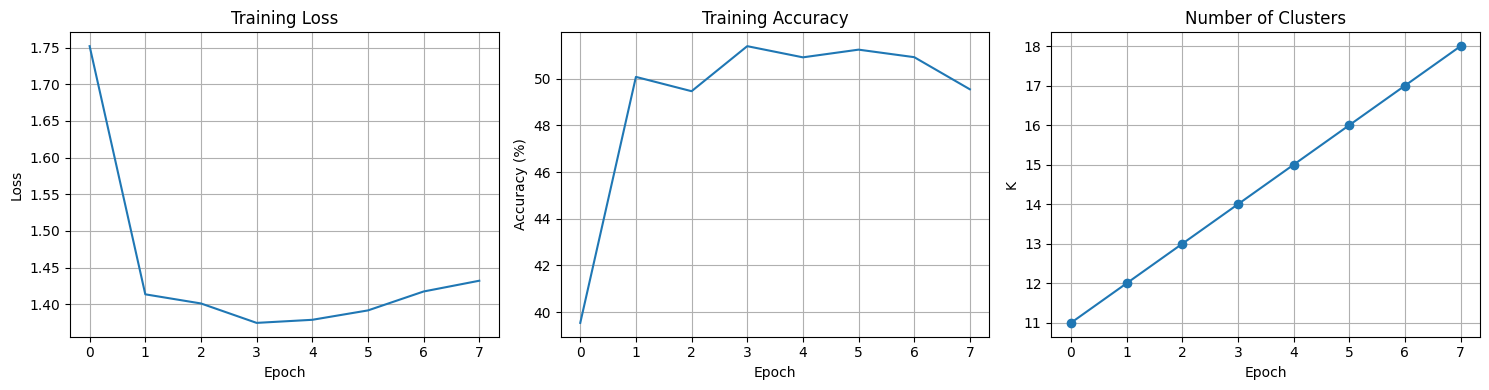

Final number of clusters: 18
Final accuracy: 49.55%


In [ ]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['train_loss'])
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

axes[1].plot(history['train_acc'])
axes[1].set_title('Training Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].grid(True)

axes[2].plot(history['num_clusters'], marker='o')
axes[2].set_title('Number of Clusters')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('K')
axes[2].grid(True)

plt.tight_layout()
plt.savefig(f'{config.CHECKPOINT_DIR}/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Final number of clusters: {clustering.k}")
print(f"Final accuracy: {history['train_acc'][-1]:.2f}%")